# Sampling a GP Prior

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelSpectralDensities.jl/blob/main/examples/3-priorGP/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelSpectralDensities.jl/dev/examples/3-priorGP/).*

**Load required packages**

In [1]:
using KernelSpectralDensities
using AbstractGPs
using StatsBase
using LinearAlgebra
using CairoMakie
using DisplayAs #hide

## Intro
We use the AbstractGPs package to define a stationary GP prior,
in other words, a GP that has not been conditioned on data yet.

In [2]:
ker = SqExponentialKernel()
S = SpectralDensity(ker, 1)

gp = GP(ker)

AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0)))

## Naive Sampling
If we want to draw a sample from the GP prior, the
standard way is to use the Cholesky decomposition of the kernel matrix.

In this example, we want to sample the GP at the following points

In [3]:
x_sample = range(0, 2; length=5)

0.0:0.5:2.0

To sample, we calculate the mean and covariance of the GP at these points.
While we use the AbstractGPs interface, in this case the mean is just
a zero vector and the covariance is the kernel matrix over the sample points.

In [4]:
m = mean(gp, x_sample)
print(m) #hide

Zeros(5)

In [5]:
K = cov(gp, x_sample)

5×5 Matrix{Float64}:
 1.0       0.882497  0.606531  0.324652  0.135335
 0.882497  1.0       0.882497  0.606531  0.324652
 0.606531  0.882497  1.0       0.882497  0.606531
 0.324652  0.606531  0.882497  1.0       0.882497
 0.135335  0.324652  0.606531  0.882497  1.0

We then compute the Cholesky decomposition of the covariance matrix
samples a vector of standard normal random variables and obtain a
sample from the GP prior.

In [6]:
function naive_sample(gp, x_sample)
    m = mean(gp, x_sample)
    K = cov(gp, x_sample)
    Kc = cholesky(K).L
    ζ = randn(length(x_sample))
    return m .+ Kc * ζ
end

ys = naive_sample(gp, x_sample)

5-element Vector{Float64}:
  0.2967399944229642
  0.7337569624775431
  0.7109768196448226
  0.06484130885013706
 -0.7831329947824509

To illustrate we plot a few samples

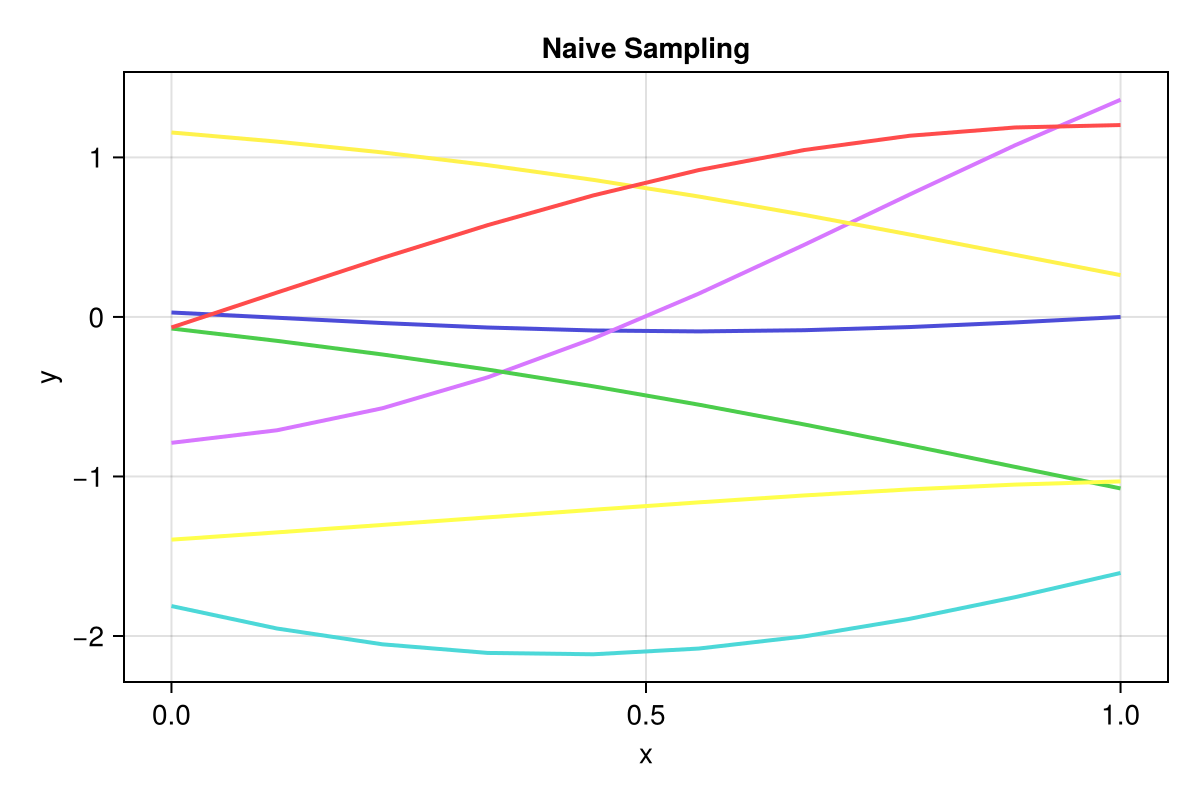

In [7]:
x_plot = range(0, 1; length=10)
n_samples = 7
ys_plot = [naive_sample(gp, x_plot) for _ in 1:n_samples]

f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="x", ylabel="y", title="Naive Sampling")
series!(ax, x_plot, reduce(hcat, ys_plot)'; labels=["sample $i" for i in 1:n_samples])
f

To evaluate the samples, we define the following function

In [8]:
function evaluate_samples(y_sample, m, K)
    ms = mean(y_sample)
    merr = norm(m .- ms)
    cs = cov(y_sample)
    cerr = norm(K .- cs)
    print("Mean error: $merr, Covariance error: $cerr\n")
    return ms, cs
end
nothing #hide

For the small number of samples we have, the results are not very good.

In [9]:
y_sample = [naive_sample(gp, x_sample) for _ in 1:n_samples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 1.1065775677400485, Covariance error: 1.8998896484813408


In [10]:
ms

5-element Vector{Float64}:
 -0.5794688178335032
 -0.5598136107954795
 -0.22244972411329306
  0.2993314125361131
  0.6604962902721757

In [11]:
cs

5×5 Matrix{Float64}:
 0.29065   0.194419  0.183246  0.228104  0.274217
 0.194419  0.258356  0.336519  0.40392   0.4525
 0.183246  0.336519  0.502234  0.612095  0.654665
 0.228104  0.40392   0.612095  0.754133  0.80299
 0.274217  0.4525    0.654665  0.80299   0.894191

If we sample a lot more functions however, we get closer to the anaytical result

In [12]:
n_manysamples = 1000
y_sample = [naive_sample(gp, x_sample) for _ in 1:n_manysamples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 0.07858837143998236, Covariance error: 0.1330340493111518


In [13]:
ms

5-element Vector{Float64}:
 0.022358098499889647
 0.04914982114781314
 0.04621869949078728
 0.026713190711969002
 0.020267705779444298

In [14]:
cs

5×5 Matrix{Float64}:
 1.00292   0.881038  0.611458  0.333656  0.146072
 0.881038  1.00222   0.896443  0.629024  0.348114
 0.611458  0.896443  1.02914   0.923627  0.647388
 0.333656  0.629024  0.923627  1.05068   0.925538
 0.146072  0.348114  0.647388  0.925538  1.02988

However, there are two issues with this approach:
1. It is quite computationally expensive, since we need to calculate the Cholesky decomposition.
2. Sampling at a larger number of points can cause conditionint issues, as we show below.

In [15]:
x_sample_many = range(0, 2; length=20)
try
    naive_sample(gp, x_sample_many)
catch err
    showerror(stderr, err)
end

PosDefException: matrix is not positive definite; Factorization failed.

## RFF Sampling
Random Fourier features are an alternative option to sample the GP prior.
Instead of computing the Cholesky decomposition of the kernel matrix, we
compute a number of Fourier features and can generate samples from the GP
by defining a weighted sum of these features.
$$
    f(x) = \sum_{i=1}^l w_i \varphi_i(x)
$$
The weights $w_i$ are sampled from a standard normal distribution.

In [16]:
rff = DoubleRFF(S, 10)
agps = ApproximateGPSample(rff)
agps.(x_sample)

5-element Vector{Float64}:
 -1.2243204810940291
 -1.3174899137345029
 -1.080446150718043
 -0.48725532775603
  0.35487036359808977

We can plot the samples as before

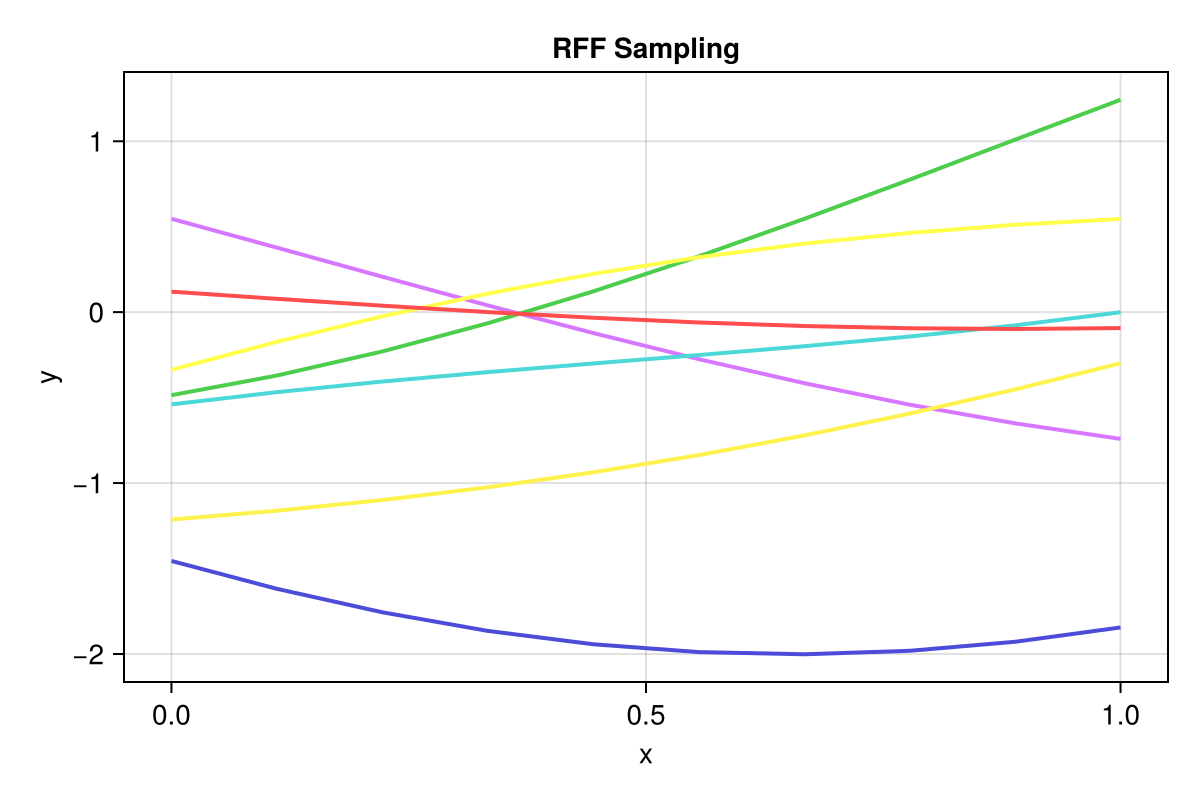

In [17]:
n_samples = 7
ys_plot = [ApproximateGPSample(rff).(x_plot) for _ in 1:n_samples]

f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="x", ylabel="y", title="RFF Sampling")
series!(ax, x_plot, reduce(hcat, ys_plot)'; labels=["sample $i" for i in 1:n_samples])
f

Unfortunately, the mean and the covariance are worse than with the naive sampling
for the same number of samples.

In [18]:
y_sample = [ApproximateGPSample(rff).(x_sample) for _ in 1:n_samples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 0.7520635829560222, Covariance error: 1.6710134097010763


In [19]:
ms

5-element Vector{Float64}:
  0.40943989195647756
  0.4861274884995006
  0.35373813318238106
  0.08982558160317741
 -0.1686397658643429

In [20]:
cs

5×5 Matrix{Float64}:
  0.991009     0.864202  0.510807  0.00667494  -0.508774
  0.864202     0.851636  0.634236  0.238636    -0.235988
  0.510807     0.634236  0.680691  0.587806     0.333183
  0.00667494   0.238636  0.587806  0.903616     1.00587
 -0.508774    -0.235988  0.333183  1.00587      1.48147

However, we now have another parameter to tune: The number of features
By increasing the number of features, we get close to the result we saw
with the naive sampling.

In [21]:
rff500 = DoubleRFF(S, 500)
y_sample = [ApproximateGPSample(rff500).(x_sample) for _ in 1:n_samples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 0.533675046074729, Covariance error: 2.8862020131809945


In [22]:
ms

5-element Vector{Float64}:
 -0.17224602277482987
  0.17491249763238154
  0.3839255904633158
  0.2776536707091589
 -0.0074539078504772815

In [23]:
cs

5×5 Matrix{Float64}:
  0.575488    0.307255   0.0307442  -0.256368   -0.453382
  0.307255    0.229221   0.139796   -0.0237629  -0.208294
  0.0307442   0.139796   0.293921    0.300699    0.103838
 -0.256368   -0.0237629  0.300699    0.508633    0.449759
 -0.453382   -0.208294   0.103838    0.449759    0.683877

By increasing the number of GP samples, we can again improve the results in
both cases.

With 10 feature functions

In [24]:
y_sample = [ApproximateGPSample(rff).(x_sample) for _ in 1:n_manysamples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 0.06303326755909625, Covariance error: 1.0399856398810348


In [25]:
ms

5-element Vector{Float64}:
 -0.029597401866102636
 -0.037810603059206506
 -0.03323403665200071
 -0.021501549108153325
 -0.010036289753455113

In [26]:
cs

5×5 Matrix{Float64}:
  1.00251    0.840384   0.450536  -0.0165565  -0.395196
  0.840384   0.985548   0.84812    0.486211    0.0435613
  0.450536   0.84812    1.02178    0.907763    0.557634
 -0.0165565  0.486211   0.907763   1.09119     0.968483
 -0.395196   0.0435613  0.557634   0.968483    1.11995

With 500 feature functions

In [27]:
y_sample = [ApproximateGPSample(rff500).(x_sample) for _ in 1:n_manysamples]
ms, cs = evaluate_samples(y_sample, m, K);

Mean error: 0.04343592507558789, Covariance error: 0.32372502991520313


In [28]:
ms

5-element Vector{Float64}:
 0.0026828250789144637
 0.009424976041045864
 0.021960957850163883
 0.02886367091345905
 0.02180038291169693

In [29]:
cs

5×5 Matrix{Float64}:
 0.957532   0.831856  0.535936  0.228028  0.0235274
 0.831856   0.966955  0.843164  0.537583  0.2266
 0.535936   0.843164  0.97405   0.846715  0.546746
 0.228028   0.537583  0.846715  0.985053  0.863933
 0.0235274  0.2266    0.546746  0.863933  0.997486

Lastly, we note that we no longer have to worry about conditioning issues,
and can evaluate a given GP sample at however many points we like

In [30]:
ApproximateGPSample(rff).(x_sample_many)

20-element Vector{Float64}:
 -0.1155931716060361
 -0.10743581332458482
 -0.08537628750223142
 -0.05067633518932606
 -0.005032122730757788
  0.049487755269516404
  0.11051550846985603
  0.1754663530668675
  0.24162715646030014
  0.30624880949651206
  0.36663950362744163
  0.4202560651701378
  0.4647905571260943
  0.49824949904088267
  0.5190232731174582
  0.5259435739645243
  0.5183271116262983
  0.4960041827409255
  0.4593311711182201
  0.4091865138227427

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/KernelSpectralDensities.jl/KernelSpectralDensities.jl/examples/3-priorGP/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.21
  &#91;7834405d&#93; AbstractGPsMakie v0.2.8
⌃ &#91;13f3f980&#93; CairoMakie v0.12.18
  &#91;0b91fe84&#93; DisplayAs v0.1.6
  &#91;027d52a2&#93; KernelSpectralDensities v0.2.0 &#96;/home/runner/work/KernelSpectralDensities.jl/KernelSpectralDensities.jl#main&#96;
  &#91;98b081ad&#93; Literate v2.20.1
  &#91;2913bbd2&#93; StatsBase v0.34.4
Info Packages marked with ⌃ have new versions available and may be upgradable.
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.11.3
Commit d63adeda50d &#40;2025-01-21 19:42 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_PKG_SERVER_REGISTRY_PREFERENCE &#61; eager
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*